# Диплом 2024

### Содержание:
- [Установка необходимых пакетов, если они не установлены](#inst_)
- [Импорт библиотек](#libr_)
- [Загрузка датасетов](#load_data_)
  - [Описание данных](#description)
- [Разведочный анализ даных (EDA)](#eda_)
  - [Посмотрим типы данных](#dtypes_)
  - [Посмотрим пропуски данных](#pass_)
  - [Посмотри статистику по датафрейму](#statistics_)
  - [Визуализируем данные](#visual_)
    - [Выделим численные признаки от даты](#num_and_char_)
    - [Создадим словарь признаков и пояснения](#translate_)
    - [Визуализируем распределение числовых признаков](#num_visual)
    - [Визуализируем распределение строковых признаков](#char_visual)
- [Предобработка признаков](#predobrabotka)
  - [Посмотрим какие признаки имеют выбросы](#vibros)
  - [Признак 'HouseYear'](#house_year)
  - [Признак 'Rooms'](#rooms)
  - [Признак 'KitchenSquare'](#kitchen_square)
  - [Признаки 'Square' и 'LifeSquare'](#square_life_square)
  - [Признаки 'HouseFloor' и 'Floor'](#floor_house_floor)
  - [Признак 'Healthcare_1'](#healthcare_1)
  - [Изменим тип признаков](#type_f)
  - [Ещё раз посмотрим скорректированные данные](#cor_data)
- [Создание класса подготовки данных](#create_class)
- [Построение новых признаков](#new_feature)
  - [DistrictSize, IsDistrictLarge (размеры районов)](#district_size)
  - [MedPriceDistrict (медиана цены квартиры в зависимости от района и количества комнат)](#med_price_district)
  - [MedPriceByFloorYear (средняя цена квартиры в зависимости от этажа и года постройки дома)](#med_price_by_floor_year)
- [Создание класса новых признаков](#create_class_2)
- [Создание модели](#create_model)
  - [Проверим модель без генерации новых фич](#model_1)
  - [Проверим модель с генерацией новых фич](#model_2)
- [Прогнозирование на тестовом датасете](#prognoz)
- [Вывод](#vivod)

### Установка пакетов если они не установлены <a class='anchor' id='inst_'>

In [1]:
# Для кождого проекта я использую новое окружение, 
# думаю это помогает избежать ошибок связанных с версиями пакетов
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install scikit-learn
# !pip install openpyxl

### Импортируем библиотеки <a class='anchor' id='libr_'>

In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Модуль для зазбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Дата и время
from datetime import datetime

# Случайные числа
import random as rnd

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score

# Пути файловой системы
from pathlib import Path

### Загружаем данные <a class='anchor' id='load_data_'>

Описание данных <a class='anchor' id='description'>
- **Id** - идентификационный номер квартиры;
- **DistrictId** - идентификационный номер района;
- **Rooms** - количество комнат;
- **Square** - площадь;
- **LifeSquare** - жилая площадь;
- **KitchenSquare** - площадь кухни;
- **Floor** - этаж;
- **HouseFloor** - количество этажей в доме;
- **HouseYear** - год постройки дома;
- **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели месности;
- **Social_1**, **Social_2**, **Social_3** - социальные показатели месности;
- **Healtcare_1**, **Heltcare_2** - показатели месности, связанные с охраной здоровья;
- **Shops_1**, **Shops_2** - показатели связанные с наличием магазинов, торговых центров;
- **Price** - цена квартиры.

In [3]:
# Расположение данных
PATH_DATASET = './Dataset'
# Минимальное количество строк в датасете
MIN_ROW = 6000


train_data = pd.DataFrame()

p = Path(Path.cwd() / PATH_DATASET)

for obj in p.iterdir():
    if obj.is_file():
        *_, name_file_all = str(obj).split('\\')
        name_file, type_file = name_file_all.split('.')
        if type_file == 'xlsx':
            df_temp = pd.read_excel(f'{PATH_DATASET}/{name_file_all}')
            # Переименуем стобцы
            df_temp.rename(columns={'Значение': f'{name_file}'}, inplace=True)
            # Нормализуем дату
            df_temp['Дата'] = df_temp['Дата'].dt.normalize()
            if train_data.shape[1]:
                if df_temp.shape[0] >= MIN_ROW:
                    print(f'Обработан {name_file_all} {df_temp.shape}')
                    train_data = pd.merge(train_data, df_temp, on='Дата', how='inner')
                    print(f'Размерность после merge {train_data.shape}')
                else:
                    print(f'Мало строк {name_file_all}')
            else:
                train_data = df_temp

Обработан eur_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 3)
Обработан gbp_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 4)
Обработан jpy_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 5)
Обработан s-p-500.xlsx (6178, 2)
Размерность после merge (5817, 6)
Обработан usd_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5817, 7)
Мало строк бивалютная-корзина_rub.xlsx
Обработан золото-(банк-россии).xlsx (6034, 2)
Размерность после merge (4951, 8)
Обработан индекс-мосбиржи.xlsx (6130, 2)
Размерность после merge (4849, 9)
Мало строк китайский-юань---российский-рубль-cny_rub-(банк-россии).xlsx
Обработан нефть-brent.xlsx (6514, 2)
Размерность после merge (4849, 10)
Обработан палладий-(банк-россии).xlsx (6838, 2)
Размерность после merge (4849, 11)
Обработан платина-(банк-россии).xlsx (6912, 2)
Размерность после merge (4849, 12)
Обработан ртс.xlsx (6128, 2)
Размерность после merge (4842, 13)
Обработан серебро-(банк-россии).xlsx (6034

In [4]:
# Посмотрим, что загрузилось
train_data.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43


In [5]:
# Посмотрим размер
train_data.shape

(4842, 14)

### Разведочный анализ даных (EDA) <a class='anchor' id='eda_'>

#### Посмотрим типы данных <a class='anchor' id='dtypes_'>

In [6]:
train_data.dtypes

Дата                      datetime64[ns]
chf_rub-(банк-россии)            float64
eur_rub-(банк-россии)            float64
gbp_rub-(банк-россии)            float64
jpy_rub-(банк-россии)            float64
s-p-500                          float64
usd_rub-(банк-россии)            float64
золото-(банк-россии)             float64
индекс-мосбиржи                  float64
нефть-brent                      float64
палладий-(банк-россии)           float64
платина-(банк-россии)            float64
ртс                              float64
серебро-(банк-россии)            float64
dtype: object

#### Посмотрим пропуски данных <a class='anchor' id='pass_'>

In [7]:
# Проверка того, в каких столбцах отсутствуют значения
print(train_data.isnull().sum(axis=0))

Дата                      0
chf_rub-(банк-россии)     0
eur_rub-(банк-россии)     0
gbp_rub-(банк-россии)     0
jpy_rub-(банк-россии)     0
s-p-500                   0
usd_rub-(банк-россии)     0
золото-(банк-россии)      0
индекс-мосбиржи           0
нефть-brent               0
палладий-(банк-россии)    0
платина-(банк-россии)     0
ртс                       0
серебро-(банк-россии)     0
dtype: int64


#### Посмотри статистику по датафрейму <a class='anchor' id='statistics_'>

In [8]:
train_data.describe()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
count,4842,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00
mean,2014-01-02 13:36:21.412639232,48.55,56.61,69.02,0.43,2188.03,47.66,2131.57,1835.95,73.48,1656.40,1633.94,1248.14,29.36
min,2003-07-07 00:00:00,20.90,32.95,40.48,0.21,682.55,23.13,333.56,391.93,19.33,144.32,600.37,427.64,4.44
25%,2008-09-24 06:00:00,23.80,37.05,49.89,0.27,1256.26,29.06,714.63,1372.19,54.17,279.26,1188.66,991.46,12.92
50%,2013-12-28 12:00:00,37.15,45.97,54.48,0.39,1804.92,34.35,1668.49,1666.57,70.95,795.39,1648.30,1209.70,30.17
75%,2019-04-01 18:00:00,66.10,73.42,86.01,0.58,2850.82,65.24,2807.79,2306.90,91.78,2782.88,1930.70,1488.71,36.00
max,2024-07-09 00:00:00,115.22,113.26,136.04,0.85,5576.98,103.16,7231.12,4287.52,146.08,8507.40,3396.33,2487.92,92.42
std,NaN,24.83,21.01,22.59,0.16,1174.85,21.14,1585.96,840.20,25.37,1728.92,593.47,401.21,18.67


### Визуализируем данные <a class='anchor' id='visual_'>

#### Выделим численные признаки от даты <a class='anchor' id='num_and_char_'>

In [9]:
# Создадим список численных признаков
num_cols = [column for column in train_data if not column=='Дата']
# Признак даты
date_cols = 'Дата'
num_cols

['chf_rub-(банк-россии)',
 'eur_rub-(банк-россии)',
 'gbp_rub-(банк-россии)',
 'jpy_rub-(банк-россии)',
 's-p-500',
 'usd_rub-(банк-россии)',
 'золото-(банк-россии)',
 'индекс-мосбиржи',
 'нефть-brent',
 'палладий-(банк-россии)',
 'платина-(банк-россии)',
 'ртс',
 'серебро-(банк-россии)']

#### Создадим словарь признаков и пояснения <a class='anchor' id='translate_'>

In [10]:
# Словарь признаков и их пояснения
explanations_col = {
    'chf_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'eur_rub-(банк-россии)': 'Евро / Российский рубль',
    'gbp_rub-(банк-россии)': 'Британский фунт стерлингов / Российский рубль',
    'jpy_rub-(банк-россии)': 'Японская иена / Российский рубль',
    's-p-500': 'Индекс S&P 500',
    'usd_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'золото-(банк-россии)': '',
    'индекс-мосбиржи': '',
    'нефть-brent': '',
    'палладий-(банк-россии)': '',
    'платина-(банк-россии)': '',
    'ртс': 'Индекс РТС',
    'серебро-(банк-россии)': '',
}

#### Визуализируем распределение числовых признаков <a class='anchor' id='num_visual'>

In [11]:
def visualization_numerical_characteristics(X=train_data, explanations_col=explanations_col, dop_text=''):
    '''
    Визуализация цифровых признаков (так сделал, чтобы код в одном месте находился).

    :param X: датасет, который будем визуализировать,
    :param explanations_col: словарь признаков и их пояснения,
    :param dop_text: добавляется дополнительный текст к заголовку.
    '''
    plt.figure(figsize=[11, 13])

    # Общий заголовок для всех графиков
    plt.suptitle('Распределение числовых признаков '  + dop_text, 
                  y=1.005, 
                  fontsize=19, 
                  fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        explanations = ''
        if not explanations_col[col] is '':
            explanations = f'\n({explanations_col[col]})'
        plt.title(f'\n{col}{explanations}', fontsize=10)
        # Задаём размер шривта и угол поворота текста для осей X и Y
        plt.xticks(fontsize=8, rotation=0)
        plt.yticks(fontsize=8, rotation=0)
        # Делаем размер шрифта по Y=5, не уберая название оси
        plt.ylabel('', fontsize=5)
        # Отрисовываем гистограмму
        plt.hist(X[col])

    # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

    # Вывести графики на экран
    plt.show()

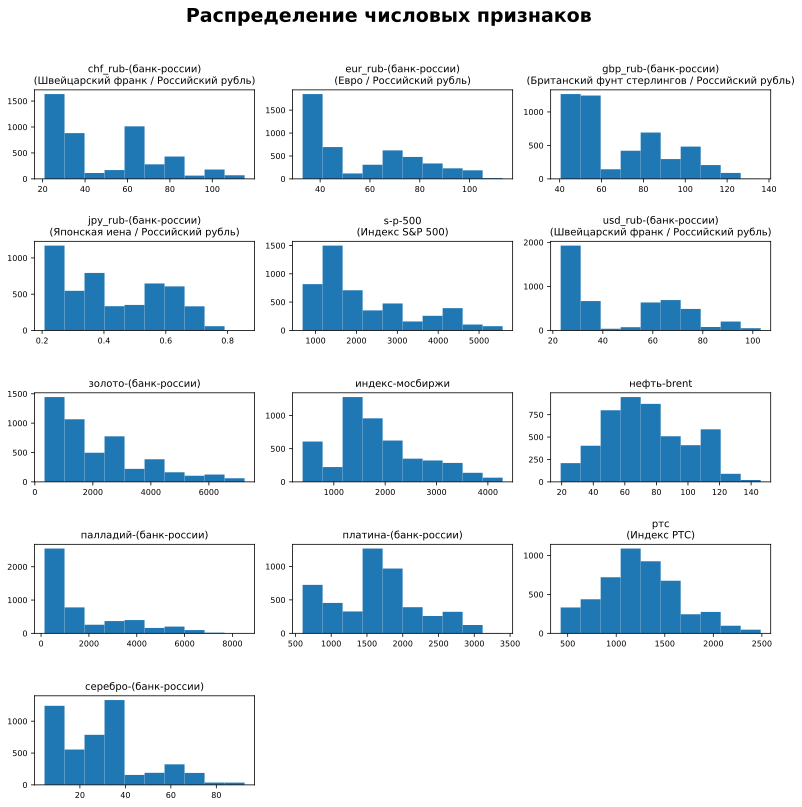

In [12]:
visualization_numerical_characteristics()

### Предобработка признаков <a class='anchor' id='predobrabotka'>

#### Посмотрим какие признаки имеют выбросы <a class='anchor' id='vibros'>

In [13]:
def emission_test(ds, col_test, threshold_val=3, explanations_col=explanations_col):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список колонок,
    :param threshold_val: пороговое значение Z-score,
    :param explanations_col: словарь признаков и их пояснения,
    :return: текстовый отчет и список выбросов.
    '''
    result = ''
    NUM = 2  # количество цифр после запятой
    outliers_list = [] # лист выбросов
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]
        
        if len(outliers) > 0:
            outliers_list.append(outliers)
            
            result += f'В столбце {col} ({explanations_col[col]}),\n{len(outliers)} выбросов. Mean: {round(ds[col].mean(), NUM)}, ' \
            f'Min: {round(ds[col].min(), NUM)}, Max: {round(ds[col].max(), NUM)}, ' \
            f'Moda: {round(ds[col].mode()[0], NUM)}, Median: {round(ds[col].median(), NUM)} \n\n'
    
    return f'Выбросов нет. ' if result == '' else result, outliers_list

In [14]:
def viev_outliers(outliers_list, col_name):
    '''
    Функция выводит строки датафрейма, в которых есть выбросы.
    
    :param outliers_list: список выбросов,
    :param col_name: название признака (фичи),
    :return: индексы выбросов.
    '''
    for item in outliers:
        if item.name == col_name:
            return item.index 

In [15]:
# Выведем признаки которые имеют выбросы
text_outliers, outliers = emission_test(ds=train_data, col_test=num_cols)

In [16]:
# Выведем текстовый отчёт по выбросам
print(text_outliers)

В столбце золото-(банк-россии) (),
23 выбросов. Mean: 2131.57, Min: 333.56, Max: 7231.12, Moda: 5993.16, Median: 1668.5 

В столбце палладий-(банк-россии) (),
22 выбросов. Mean: 1656.4, Min: 144.32, Max: 8507.4, Moda: 3275.71, Median: 795.39 

В столбце ртс (Индекс РТС),
6 выбросов. Mean: 1248.14, Min: 427.64, Max: 2487.92, Moda: 982.94, Median: 1209.7 

В столбце серебро-(банк-россии) (),
23 выбросов. Mean: 29.36, Min: 4.44, Max: 92.42, Moda: 32.11, Median: 30.17 




### Test

In [17]:
# Модуль для работы с временными рядами
from sklearn.model_selection import TimeSeriesSplit

In [18]:
# Создадим дополнительные признаки (Год, Месяц, День, День недели (Пн-Вс))
train_data['Year'] = train_data['Дата'].dt.year
train_data['Month'] = train_data['Дата'].dt.month
train_data['Weekday'] = train_data['Дата'].dt.weekday
train_data['Day'] = train_data['Дата'].dt.day

train_data

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии),Year,Month,Weekday,Day
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68,2024,7,1,9
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96,2024,7,0,8
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36,2024,7,4,5
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73,2024,7,2,3
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43,2024,7,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,2003-07-11,22.37,34.49,49.63,0.26,998.14,30.36,334.52,427.26,29.19,158.11,609.87,462.20,4.62,2003,7,4,11
4838,2003-07-10,22.23,34.48,49.73,0.26,988.70,30.42,333.56,433.37,28.88,155.32,607.73,478.14,4.53,2003,7,3,10
4839,2003-07-09,22.15,34.43,50.06,0.26,1002.21,30.36,336.15,446.69,28.71,155.59,601.56,493.77,4.49,2003,7,2,9
4840,2003-07-08,22.41,34.70,50.49,0.26,1007.84,30.30,335.33,463.13,27.97,158.89,600.37,513.33,4.45,2003,7,1,8


In [19]:
train_data.dtypes

Дата                      datetime64[ns]
chf_rub-(банк-россии)            float64
eur_rub-(банк-россии)            float64
gbp_rub-(банк-россии)            float64
jpy_rub-(банк-россии)            float64
s-p-500                          float64
usd_rub-(банк-россии)            float64
золото-(банк-россии)             float64
индекс-мосбиржи                  float64
нефть-brent                      float64
палладий-(банк-россии)           float64
платина-(банк-россии)            float64
ртс                              float64
серебро-(банк-россии)            float64
Year                               int32
Month                              int32
Weekday                            int32
Day                                int32
dtype: object

In [20]:
def not_correct_year(df=train_data, min_month=12, min_day=200):
    '''
    Функция выдает список не корректных годов, где min_month и min_day меньше заданного.

    :param  df: исследуемый датафрейм,
    :param  min_month: минимальное количество месяцев в году,
    :param  min_day: минимальное количество дней в году,
    :return: возвращает список не корректных годов и текстовый отчёт.
    '''

    not_corr_year = []
    txt_report = ''
    
    for year in df['Year'].unique():
        month_quantity = len(df[df['Year']==year]['Month'].unique())
        day_quantity = len(df[df['Year']==year]['Weekday'])
        if (month_quantity < min_month) or (day_quantity < min_day):
            not_corr_year.append(int(year))
        txt_report += f'Год: {year}, кол. месяцев: {month_quantity}, кол. дней: {day_quantity}\n'

    return not_corr_year, txt_report

In [21]:
# Протестируем датасет и запишем список не корректных годов и отчёт
not_correct_year_list, report = not_correct_year()
print(report)

Год: 2024, кол. месяцев: 7, кол. дней: 124
Год: 2023, кол. месяцев: 12, кол. дней: 237
Год: 2022, кол. месяцев: 12, кол. дней: 214
Год: 2021, кол. месяцев: 12, кол. дней: 233
Год: 2020, кол. месяцев: 12, кол. дней: 225
Год: 2019, кол. месяцев: 12, кол. дней: 232
Год: 2018, кол. месяцев: 12, кол. дней: 227
Год: 2017, кол. месяцев: 12, кол. дней: 232
Год: 2016, кол. месяцев: 12, кол. дней: 232
Год: 2015, кол. месяцев: 12, кол. дней: 231
Год: 2014, кол. месяцев: 12, кол. дней: 233
Год: 2013, кол. месяцев: 12, кол. дней: 232
Год: 2012, кол. месяцев: 12, кол. дней: 230
Год: 2011, кол. месяцев: 12, кол. дней: 232
Год: 2010, кол. месяцев: 12, кол. дней: 224
Год: 2009, кол. месяцев: 12, кол. дней: 230
Год: 2008, кол. месяцев: 12, кол. дней: 226
Год: 2007, кол. месяцев: 12, кол. дней: 227
Год: 2006, кол. месяцев: 12, кол. дней: 232
Год: 2005, кол. месяцев: 12, кол. дней: 231
Год: 2004, кол. месяцев: 12, кол. дней: 235
Год: 2003, кол. месяцев: 6, кол. дней: 123



In [30]:
# Создадим новый датафрейм в котором не будет не корректных годов
X = train_data.loc[~train_data['Year'].isin(not_correct_year_list)]
# Посмотрим статистику
(X['Year'].min(), X['Year'].max())

(np.int32(2004), np.int32(2023))

In [ ]:
[col for col in df.columns if col not in ("Exclude1", "Exclude2")]

In [ ]:
train_data.columns

In [ ]:
train_data['Дата'].dt.month.uniqum()

In [ ]:
train_data[(train_data['Дата'].dt.year > 2000)]

In [ ]:
x = train_data.groupby([train_data['Дата'].dt.year, train_data['Дата'].dt.month]).count()
# x = train_data.groupby([train_data['Дата'].dt.year, train_data['Дата'].dt.month])[['s-p-500', 'Дата']].count()

In [ ]:
type(x)

x.shape
# X = train_data[]
# b.query('(col1 < 6) & (col2 > "c")')

In [ ]:
g = x.to_numpy()
g.shape

In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])

tscv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
train_data['Дата'].min(), train_data['Дата'].max()

In [ ]:
train_data['Дата'].max() - train_data['Дата'].min() 

In [ ]:
train_data[train_data[train_data.groupby(train_data['Дата'].dt.year)]]


In [ ]:
tscv = TimeSeriesSplit(n_splits=15)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
for item in test:
    print(item)

#### Признак 'HouseYear' <a class='anchor' id='house_year'>

In [ ]:
# Посмотрим даты, которые больше текущей даты 
train_data[train_data['HouseYear'] > datetime.now().year]

**Изменения:**

In [ ]:
# Признак 'HouseYear'
# Заменим все года постройки, которые больше текущего года на моду
train_data.loc[train_data['HouseYear'] > datetime.now().year, ['HouseYear']] = train_data['HouseYear'].mode()[0]

In [ ]:
# Посмотрим статиску
train_data['HouseYear'].describe()

In [ ]:
# Посмотрим выбросы
print(emission_test(ds=train_data, col_test=['HouseYear'])[0])

**Вывод:** Убрал слишком большие даты, заменил их на моду. 

#### Признак 'Rooms' <a class='anchor' id='rooms'>

In [ ]:
# Посмотрим выбросы и цену
train_data.loc[viev_outliers(outliers, 'Rooms')].sort_values(by='Rooms')

In [ ]:
# Посмотрим количесиво квартир с различными комнатами
train_data['Rooms'].value_counts()

In [ ]:
# Посмотрим квартиры с 0 комнат и ценой
train_data.query('(Rooms == 0)')

**Измения:**

In [ ]:
# Признак 'Rooms'
# Создадим индексы строк в которых 5 и более комнат, а их площадь менее 100 или меньше одной комнаты
index_edit = train_data.query('(((Rooms >= 5) & (Square < 100)) | (Rooms < 1))').index
# Заменим аномальные значения на медиану
train_data.loc[index_edit, ['Rooms']] = train_data['Rooms'].median()

In [ ]:
# Посмотрим статиску
train_data['Rooms'].describe()

In [ ]:
# Посмотрим выбросы
print(emission_test(ds=train_data, col_test=['Rooms'])[0])

**Вывод:** Исправил квартиры с нулём комнат и более 5 комнат.

#### Признак 'KitchenSquare' <a class='anchor' id='kitchen_square'>

In [ ]:
# Посмотрим выбросы
train_data.loc[viev_outliers(outliers, 'KitchenSquare')].sort_values(by='KitchenSquare')

In [ ]:
# Посмотрим какие кухни есть
train_data['KitchenSquare'].value_counts().sort_values()

In [ ]:
# Посмотрим квартиры без кухни
train_data.query('(KitchenSquare == 0)').sort_values(by='Square')

In [ ]:
# Посмотрим квартиры с кухней > 20
train_data.query('(KitchenSquare > 20)').sort_values(by='KitchenSquare')

In [ ]:
# Посмотрим квартиры с кухней > 35
train_data.query('(KitchenSquare > 35)').sort_values(by='KitchenSquare')

In [ ]:
# Посмотрим квантили
train_data['KitchenSquare'].quantile(0.975), train_data['KitchenSquare'].quantile(0.025)

In [ ]:
# Посмотрим медиану
train_data['KitchenSquare'].median()

**Изменения:**

In [ ]:
# Признак 'KitchenSquare'
# Заменим все кухни, которые больше 35 квадратов на медиану
train_data.loc[train_data['KitchenSquare'] > 35, ['KitchenSquare']] = train_data['KitchenSquare'].median()

In [ ]:
train_data['KitchenSquare'].describe()

In [ ]:
# Посмотрим выбросы
print(emission_test(ds=train_data, col_test=['KitchenSquare'])[0])

**Вывод:** Убрал только кухни больше 35 $м^{2}$. Без кухни или совсем маленькие - это может быть комуналка или студия.

#### Признаки 'Square' и 'LifeSquare' <a class='anchor' id='square_life_square'>

In [ ]:
# Посмотрим выбросы
train_data.loc[viev_outliers(outliers, 'Square')].sort_values(by='Square')

In [ ]:
# Посмотрим количество уникальных площадей квартир
len(train_data['Square'].unique())

In [ ]:
# Посмотрим количество
train_data['Square'].value_counts().sort_values()

In [ ]:
# Посмотрим количество
train_data['LifeSquare'].value_counts().sort_values()

In [ ]:
# Посмотрим квартиры < 20 м
train_data.query('(Square < 20)').sort_values(by='Square')

In [ ]:
# Посмотрим квартиры 1 м
train_data.query('(Square == 1)')

In [ ]:
# Посмотрим квартиры в которых общая площадь меньше жилой площади
train_data.query('(Square < LifeSquare)').sort_values(by='Square')

In [ ]:
# Посмотрим статистику
train_data['LifeSquare'].describe()

In [ ]:
# Посмотрим квартиры с жилой площадью больше максимальной площади
train_data[train_data['LifeSquare'] > train_data['Square'].max()]

**Изменения:**

In [ ]:
# Признаки 'Square' и 'LifeSquare'
# Чтобы метраж у каждой квартиры, был уникальным - маловероятно. Округлим метраж до целых чисел
train_data['Square'] = train_data['Square'].apply(lambda x: round(x, 0))
train_data['LifeSquare'] = train_data['LifeSquare'].apply(lambda x: round(x, 0))

# Заменим экстримальные значения LifeSquare
train_data.loc[(train_data['LifeSquare'] > train_data['Square'].max()), ['LifeSquare']] = train_data['Square']

Оказывается есть квартиры 4,8 метра, не веришь смотри [видео](https://www.youtube.com/watch?v=15QK4Mg4wEU). Так, что это не выбросы. 

In [ ]:
# Заменим совсем уж маленькую площадь
train_data.loc[(train_data['Square'] < 5), ['Square']] = 5

# Заменим не корректные значения Square на LifeSquare + KitchenSquare
train_data.loc[(train_data['Square'] < train_data['LifeSquare']), ['Square']] = train_data['LifeSquare'] + train_data['KitchenSquare']

# Заменим не корректные значения LifeSquare на Square - KitchenSquare
train_data.loc[(train_data['Square'] == train_data['LifeSquare']), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

# Заменим недостающие значения LifeSquare или значения < 20.   LifeSquare = Square - KitchenSquare
train_data.loc[((train_data['LifeSquare'].isna()) | (train_data['LifeSquare'] < 20)), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

In [ ]:
# Посмотрим статистику Floor и HouseFloor
train_data.describe()

In [ ]:
# Посмотрим выбросы после чистки данных
print(emission_test(ds=train_data, col_test=['Square', 'LifeSquare'])[0])

In [ ]:
# Сформируем таблицу выбросов для 'Square' и 'LifeSquare'
outliers = emission_test(ds=train_data, col_test=['Square', 'LifeSquare'])[1]
# Посмотрим выбросы в Square после чистки данных
train_data.loc[viev_outliers(outliers, 'Square')].sort_values(by='Square')

In [ ]:
# Посмотрим выбросы в LifeSquare после чистки данных
train_data.loc[viev_outliers(outliers, 'LifeSquare')].sort_values(by='LifeSquare')

**Вывод:** Думаю, что квартиры (помещения) $5м^{2}$ и $641м^{2}$ могут существовать, поэтому я их не удалил.

#### Признаки 'HouseFloor' и 'Floor' <a class='anchor' id='floor_house_floor'>

In [ ]:
# Посмотрим сколько этажей у домов
train_data['HouseFloor'].sort_values().unique()

In [ ]:
# Посмотрим какие этажи у квартир
train_data['Floor'].sort_values().unique()

In [ ]:
# Посмотрим сколько квартир в которых, этаж квартиры больше, чем этажность дома
(train_data['Floor'] > train_data['HouseFloor']).sum()

In [ ]:
# Сформируем таблицу выбросов для 'HouseFloor' и 'Floor'
outliers = emission_test(ds=train_data, col_test=['HouseFloor', 'Floor'])[1]
# Посмотрим выбросы в HouseFloor 
train_data.loc[viev_outliers(outliers, 'HouseFloor')].sort_values(by='HouseFloor')

In [ ]:
# Посмотрим экстримальные значения
train_data[train_data['HouseFloor'] < 1]

In [ ]:
# Посмотрим выбросы Floor
train_data.loc[viev_outliers(outliers, 'Floor')].sort_values(by='Floor')

In [ ]:
# Посмотрим экстримальные значения Floor
train_data[train_data['Floor'] < 1]

**Изменения:**

In [ ]:
def random_floor(floor):
    '''
    Процедура выбора случайной этажности дома для определённой квартиры.

    :param floor: этаж на которой расположена квартира,
    :return: случайная этажность дома или -1, если такого этажа не может быть.
    '''
    
    # Список с этажносстью домов
    house_floor_list = [5, 9, 14, 16, 24, 40, 48]
    # Веса выбора этажности (тоесть многоэтажки 40, 48 выпадают реже)
    weights = [5, 10, 20, 20, 10, 2, 1]
    # Скорректированные веса выбора этажности дома в зависимости от этажа текущей квартиры
    weights_corr = [weights[i] if house_floor_list[i] >= floor else 0 for i in range(len(weights))]
 
    if sum(weights_corr):
        house_floor = rnd.choices(house_floor_list, weights=weights_corr, k=1)
        return house_floor[0]
    else:
        return -1

In [ ]:
# Признаки 'HouseFloor' и 'Floor'
# Зададим начальное значение модуля rnd
rnd.seed(42)
# Заменим ошибочную этажность дома на релевантную 
train_data['HouseFloor'] = train_data['Floor'].apply(lambda x: random_floor(x))

In [ ]:
# Посмотрим дома этажностью менее 5 и этаж квартиры больше этажности дома
train_data.query('(Floor > HouseFloor) | (HouseFloor < 5)')

In [ ]:
# Посмотрим выбросы после чистки данных
print(emission_test(ds=train_data, col_test=['Floor', 'HouseFloor'])[0])

In [ ]:
# Сформируем таблицу выбросов для 'Floor' и 'HouseFloor'
outliers = emission_test(ds=train_data, col_test=['Floor', 'HouseFloor'])[1]
# Посмотрим выбросы в Floor после чистки данных
train_data.loc[viev_outliers(outliers, 'Floor')].sort_values(by='Floor')

In [ ]:
# Посмотрим выбросы в HouseFloor после чистки данных
train_data.loc[viev_outliers(outliers, 'HouseFloor')].sort_values(by='HouseFloor')

**Вывод:** Заменил не корректную этажность домов.

#### Признак 'Healthcare_1' <a class='anchor' id='healthcare_1'>

**Изменения:**

In [ ]:
# Признак 'Healthcare_1'
# В фиче 'Healthcare_1' пропущено 50% записей - этот признак не информативен, удалим его
train_data.drop('Healthcare_1', axis=1, inplace=True)

#### Изменим тип признаков <a class='anchor' id='type_f'>

**Изменения:**

In [ ]:
# Изменим тип признаков
le = LabelEncoder()
# Пробежимся по столбцам датафрейма и преобразуем буквеное обозначение в цифровое
for col in str_cols:
    train_data[col] = le.fit_transform(train_data[col].astype(str))

In [ ]:
train_data.dtypes

In [ ]:
# Переведём Id квартиры в строковый формат
train_data['Id'] = train_data['Id'].astype(str)
train_data['Id'].dtypes

#### Ещё раз посмотрим скорректированные данные <a class='anchor' id='cor_data'>

In [ ]:
# Разделим числовые и строковые признаки
num_cols, str_cols = numeric_and_string_attributes(train_data)
# Посмотрим визуально на графики числовых переменных
visualization_numerical_characteristics(dop_text='(после чистки данных)')

### Создание класса подготовки данных <a class='anchor' id='create_class'>

In [ ]:
class DataPreprocessing():
    '''
    Класс 'Подготовки исходных данных'

     Атрибуты:
    - kitchen_square_median: медиана площади кухни,
    - rooms_median: медиана количества комнат,
    - house_year_mode: мода года постройки дома.

     Методы:
    - random_floor(self, floor) -> int:  выбор случайной этажности дома для определённой квартиры,
    - numeric_and_string_attributes(self, df): разделяет числовые и строковые признаки,
    - fit(self, X): сохраняет медианы и моды, для последующего использования,
    - transform (self, X): чистит наш датафрейм (заполняет пропуски, исправляет неточности).

     Dunder методы:
    - __init__(self): конструктор класса,
    '''

    def __init__(self):
        # Переменные лласса
        self.house_year_mode = None
        self.kitchen_square_median = None
        self.rooms_median = None

    @staticmethod
    def random_floor(self, floor) -> int:
        '''
        Процедура выбора случайной этажности дома для определённой квартиры.
    
        :param floor: этаж на которой расположена квартира,
        :return: случайная этажность дома или -1, если такого этажа не может быть.
        '''
        
        # Список с этажносстью домов
        house_floor_list = [5, 9, 14, 16, 24, 40, 48]
        # Веса выбора этажности (тоесть многоэтажки 40, 48 выпадают реже)
        weights = [5, 10, 20, 20, 10, 2, 1]
        # Скорректированные веса выбора этажности дома в зависимости от этажа текущей квартиры
        weights_corr = [weights[i] if house_floor_list[i] >= floor else 0 for i in range(len(weights))]
     
        if sum(weights_corr):
            house_floor = rnd.choices(house_floor_list, weights=weights_corr, k=1)
            return house_floor[0]
        else:
            return -1

    @staticmethod
    def numeric_and_string_attributes(self, df):
        '''
        Функция разделяет числовые и строковые признаки.
    
        :param df: исследуемый датафрейм,
        :return: num_cols - список числовых признаков, str_cols - список строковых признаков.
        '''
        # Числовые признаки
        num_cols = []
        # Строковые признаки
        str_cols = []
        
        cols_and_type = df.dtypes.to_dict()
        
        for col in cols_and_type:
            if cols_and_type[col] in ('int64', 'float64'):
                num_cols.append(col)
            else: 
                str_cols.append(col)
    
        return num_cols, str_cols
    
    def fit(self, X):
        '''
        Функция сохраняет статистические данные (медиана, мода)

        :param X: исследуемый датафрейм.
        '''
        self.house_year_mode = X['HouseYear'].mode()[0]
        self.kitchen_square_median = X['KitchenSquare'].median()
        self.rooms_median = X['Rooms'].median()
        
    
    def transform (self, X):
        '''
        Функция чистит данные.

        :param X: исследуемый датафрейм,
        :return: возвращает очищенный датафрейм.
        '''
        # Признак 'HouseYear'
        # Заменим все года постройки, которые больше текущего года на моду
        X.loc[X['HouseYear'] > datetime.now().year, ['HouseYear']] = self.house_year_mode

        
        # Признак 'Rooms'
        # Создадим индексы строк в которых 5 и более комнат, а их площадь менее 100 или меньше одной комнаты
        index_edit = X.query('(((Rooms >= 5) & (Square < 100)) | (Rooms < 1))').index
        # Заменим аномальные значения на медиану
        X.loc[index_edit, ['Rooms']] = self.rooms_median

        
        # Признак 'KitchenSquare'
        # Заменим все кухни, которые больше 35 квадратов на медиану
        X.loc[X['KitchenSquare'] > 35, ['KitchenSquare']] = self.kitchen_square_median


        # Признаки 'Square' и 'LifeSquare'
        # Чтобы метраж у каждой квартиры, был уникальным - маловероятно. Округлим метраж до целых чисел
        X['Square'] = X['Square'].apply(lambda x: round(x, 0))
        X['LifeSquare'] = X['LifeSquare'].apply(lambda x: round(x, 0))
        # 
        # Заменим экстримальные значения LifeSquare
        X.loc[(X['LifeSquare'] > X['Square'].max()), ['LifeSquare']] = X['Square']
        # 
        # Заменим совсем уж маленькую площадь
        X.loc[(X['Square'] < 5), ['Square']] = 5
        # 
        # Заменим не корректные значения Square на LifeSquare + KitchenSquare
        X.loc[(X['Square'] < X['LifeSquare']), ['Square']] = X['LifeSquare'] + X['KitchenSquare']
        # 
        # Заменим не корректные значения LifeSquare на Square - KitchenSquare
        X.loc[(X['Square'] == X['LifeSquare']), ['LifeSquare']] = X['Square'] - X['KitchenSquare']
        # 
        # Заменим недостающие значения LifeSquare или значения < 20.   LifeSquare = Square - KitchenSquare
        X.loc[((X['LifeSquare'].isna()) | (X['LifeSquare'] < 20)), ['LifeSquare']] = X['Square'] - X['KitchenSquare']


        # Признаки 'HouseFloor' и 'Floor'
        # Зададим начальное значение модуля rnd
        rnd.seed(42)
        # Заменим ошибочную этажность дома на релевантную 
        X['HouseFloor'] = X['Floor'].apply(lambda x: self.random_floor(self, x))


        # Признак 'Healthcare_1'
        # В фиче 'Healthcare_1' пропущено 50% записей - этот признак не информативен, удалим его
        X.drop('Healthcare_1', axis=1, inplace=True)

        # Разделим числовые и строковые признаки
        num_cols, str_cols = self.numeric_and_string_attributes(self, X)

        # Изменим тип признаков
        le = LabelEncoder()
        # Пробежимся по строковым столбцам датафрейма и преобразуем буквеное обозначение в цифровое
        for col in  str_cols:
            X[col] = le.fit_transform(X[col].astype(str))
        # 
        # Переведём Id квартиры в строковый формат
        X['Id'] = X['Id'].astype(str)

        return X

In [ ]:
# Проверим как работает
# Читаем csv файл тренировочных данных
train_data_new = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

In [ ]:
# Создадим объект класса
dp = DataPreprocessing()
# Сохраним стат. данные 
dp.fit(train_data_new)
# Сохраним очищенный датасет
proverka = dp.transform(train_data_new)
# Сравним два датафрейма (который изменили ранее и изменённый с помощью объекта класса)
proverka.equals(train_data)

**Ура!!!** Значит я ничего не упустил в классе. Датафрйм изменённый ранее и датафрейм изменённый с помощью объекта класса, совпадают.

### Построение новых признаков <a class='anchor' id='new_feature'>

#### DistrictSize, IsDistrictLarge (размеры районов) <a class='anchor' id='district_size'>

In [ ]:
# Посмотрим как распределены номера районов
district_size = train_data['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'count': 'DistrictSize'})
district_size.head()

In [ ]:
# Добавим 'DistrictSize' к нашему датафрейму
train_data = train_data.merge(district_size, on='DistrictId', how='left')
train_data.head()

In [ ]:
# Посмотрим как распределяется 'DistrictSize'
(train_data['DistrictSize'] > 100).value_counts()

In [ ]:
# Добавим новый признак 'IsDistrictLarge'
train_data['IsDistrictLarge'] = (train_data['DistrictSize'] > 100).astype(int)
train_data.head()

#### MedPriceDistrict (медиана цены квартиры в зависимости от района и количества комнат) <a class='anchor' id='med_price_district'>

In [ ]:
# Средняя цена квартиры в зависимости от района и количества комнат
med_price_by_district = train_data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})  
med_price_by_district.head()

In [ ]:
# Добавляем этот признак в датафрейм
train_data = train_data.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_data.head()

#### MedPriceByFloorYear (средняя цена квартиры в зависимости от этажа и года постройки дома) <a class='anchor' id='med_price_by_floor_year'>

In [ ]:
def floor_to_cat(X):
    '''
    Функция разбивает квартиры на категории в зависимости от этажа.

    :param X: исследуемый датафрейм,
    :return: датафрейм с признаком категории этажности.
    '''
    # Этот код анологичен встроенной функии Pandas pd.cut
    # X['floor_cat'] = 0

    # X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    # X.loc[X['Floor'] > 3, 'floor_cat'] = 2
    # X.loc[X['Floor'] > 5, 'floor_cat'] = 3
    # X.loc[X['Floor'] > 9, 'floor_cat'] = 4
    # X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    # На сколько категорий будем делить: 0-3, 3-5, 5-9, 15-max
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['floor_cat'].fillna(-1, inplace=True)
    
    return X

In [ ]:
def year_to_cat(X):
    '''
    Функция разбивает квартиры на категории в зависимости от года постройки дома.

    :param X: исследуемый датафрейм,
    :return: датафрейм с признаком категории постройки дома.
    '''

    # Этот код анологичен встроенной функии Pandas pd.cut
    # X['year_cat'] = 0

    # X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    # X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    # X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    # X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    # X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    # X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['year_cat'].fillna(-1, inplace=True)

    return X

In [ ]:
# Создадим дополнительные признаки
train_data = year_to_cat(train_data)
train_data = floor_to_cat(train_data)
train_data.head()

In [ ]:
# Рассчитаем среднею стоимость по этажам и по году
med_price_by_floor_year = train_data.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

In [ ]:
# Добавим новый признак в датафрейм
train_data = train_data.merge(med_price_by_floor_year, on=['year_cat','floor_cat'], how='left')
train_data.head()

### Создание класса новых признаков <a class='anchor' id='create_class_2'>

In [ ]:
class FeatureGenerator():
    '''
    Класс 'Генерации новых фич'

     Атрибуты:
    - house_year_max: максимальный год постройки дома,
    - floor_max: максимальное число комнат,
    - med_price_by_district: средняя цена квартиры в зависимости от района и количества комнат,
    - med_price_by_floor_year: средняя стоимость по этажам и по году постройки дома.

     Методы:
    - fit(self, X): сохраняет макс. значения и другие параметры, для последующего использования,
    - transform (self, X): добавляет новые фичи в датафрейм.

     Dunder методы:
    - __init__(self): конструктор класса,
    '''

    def __init__(self):
        # Переменные лласса
        self.house_year_max = None
        self.floor_max = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    
    def fit(self, X):
        '''
        Функция сохраняет необходимые данные.

        :param X: исследуемый датафрейм.
        '''
        self.house_year_max = X['HouseYear'].max()
        self.floor_max = X['Floor'].max()
        
    
    def transform (self, X):
        '''
        Функция добавляет новые фичи.

        :param X: исследуемый датафрейм,
        :return: возвращает датафрейм с новыми фичами.
        '''
        x = X.copy()

        # Посмотрим как распределены номера районов
        district_size = x['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'count': 'DistrictSize'})
        # Добавим 'DistrictSize' к нашему датафрейму
        x = x.merge(district_size, on='DistrictId', how='left')
        
        # Добавим новый признак 'IsDistrictLarge'
        x['IsDistrictLarge'] = (x['DistrictSize'] > 100).astype(int)

        if self.med_price_by_district is None:
            # Средняя цена квартиры в зависимости от района и количества комнат
            self.med_price_by_district = x.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})  
        # Добавляем этот признак в датафрейм
        x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

        # Категории постройки дома (год)
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        x['year_cat'] = pd.cut(x['HouseYear'], bins=bins, labels=False)
        x['year_cat'].fillna(-1, inplace=True)

        # На сколько категорий будем делить этажность дома: 0-3, 3-5, 5-9, 15-max
        bins = [0, 3, 5, 9, 15, self.floor_max]
        x['floor_cat'] = pd.cut(x['Floor'], bins=bins, labels=False)
        x['floor_cat'].fillna(-1, inplace=True)

        if self.med_price_by_floor_year is None:
            # Рассчитаем среднею стоимость по этажам и по году
            self.med_price_by_floor_year = x.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedPriceByFloorYear'})
        # Добавим новый признак в датафрейм
        x = x.merge(self.med_price_by_floor_year, on=['year_cat','floor_cat'], how='left')
        
        return x

In [ ]:
# Проверим как работает
# Читаем csv файл тренировочных данных
train_data_new = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

In [ ]:
# Создадим объект класса
dp = DataPreprocessing()
# Сохраним стат. данные 
dp.fit(train_data_new)
# Сохраним очищенный датасет
proverka = dp.transform(train_data_new)

# Создадим объект класса
fg = FeatureGenerator()
# Сохраним стат. данные 
fg.fit(proverka)
# Сгенерим дополнительные фичи
proverka = fg.transform(proverka)
# Сравним два датафрейма (который изменили ранее и изменённый с помощью объекта класса)
proverka.equals(train_data)

**Ура!!!** Значит я ничего не упустил в классе. Датафрйм изменённый ранее и датафрейм с новыми фичами, изменённый с помощью объекта класса, совпадают.

### Создание модели <a class='anchor' id='create_model'>

#### Проверим модель без генерации новых фич <a class='anchor' id='model_1'>

In [ ]:
# Читаем csv файл тренировочных данных
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
# Читаем csv файл тестовых данных
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')

# Создадим объект класса
dp = DataPreprocessing()
# Сохраним стат. данные 
dp.fit(train_data)
# Сохраним очищенный датасет (train)
X = dp.transform(train_data)
# Сохраним очищенный датасет (test)
test_data = dp.transform(test_data)

# Создадим целевую переменную (таргет)
y = X['Price']
# Удалим таргет из тренировочных данных
X_not_price = X.drop('Price', axis=1)

In [ ]:
# Разобьём выборку на тренировочную (70%) и валидную (30%)
X_train, X_valid, y_train, y_valid = train_test_split(X_not_price, y, test_size=0.3, random_state=42)

In [ ]:
# Посмотрим размерность датафремов
(X_train.shape, X_valid.shape, test_data.shape)

In [ ]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [ ]:
%%time
# Обучим модель
rf_model.fit(X_train, y_train) 

In [ ]:
%%time
# Выполним обучение модели с кросс-валидацией
cv = cross_validate(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

In [ ]:
# Средняя эффективность по метрике r2
print(f'Средняя эффективность по метрике r2: {cv['test_score'].mean()}')

In [ ]:
# Задаем размер фигуры
plt.rcParams['figure.figsize'] = 6, 4
# Задаём данные для отрисовки
plt.barh(X_train.keys().tolist(), np.sort(rf_model.feature_importances_))
# Подписываем оси
plt.xlabel("Важность признака")
plt.ylabel("Признак")

plt.show()

Оценим точность модели на данных, которые она не видела (X_valid, y_valid)

In [ ]:
# Выполним предикт
y_pred = rf_model.predict(X_valid)
# Посмотрим эффективность модели по метрике r2
print(f'Эффективность модели по метрике r2: {r2_score(y_valid, y_pred)}')

#### Проверим модель с генерацией новых фич <a class='anchor' id='model_2'>

In [ ]:
# Создадим объект класса
fg = FeatureGenerator()
# Сохраним стат. данные 
fg.fit(X)
# Сгенерим дополнительные фичи (train)
X_new_features = fg.transform(X)
# Удалим таргет из тренировочных данных
X_new_features = X_new_features.drop('Price', axis=1)
# Сгенерим дополнительные фичи (test)
test_data = fg.transform(test_data)

# Посмотрим, что получилось 
X_new_features.head()

In [ ]:
# Разобьём выборку на тренировочную (70%) и валидную (30%)
X_train, X_valid, y_train, y_valid = train_test_split(X_new_features, y, test_size=0.3, random_state=42)

In [ ]:
# Посмотрим размерность датафремов
(X_train.shape, X_valid.shape, test_data.shape)

In [ ]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model_new_features = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [ ]:
%%time
# Обучим модель
rf_model_new_features.fit(X_train, y_train)

In [ ]:
%%time
# Выполним обучение модели с кросс-валидацией
cv = cross_validate(rf_model_new_features, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

In [ ]:
# Средняя эффективность по метрике r2
print(f'Средняя эффективность по метрике r2: {cv['test_score'].mean()}')

In [ ]:
# Задаем размер фигуры
plt.rcParams['figure.figsize'] = 7, 6
# Задаём данные для отрисовки
plt.barh(X_train.keys().tolist(), np.sort(rf_model_new_features.feature_importances_))
# Подписываем оси
plt.xlabel("Важность признака")
plt.ylabel("Признак")

plt.show()

Оценим точность модели на данных, которые она не видела (X_valid, y_valid)

In [ ]:
# Выполним предикт
y_pred = rf_model_new_features.predict(X_valid)
# Посмотрим эффективность модели по метрике r2
print(f'Эффективность модели по метрике r2: {r2_score(y_valid, y_pred)}')

### Прогнозирование на тестовом датасете <a class='anchor' id='prognoz'>

In [ ]:
# Посмотрим размерность датасета
test_data.shape

In [ ]:
# Выполняем предикт
predictions = rf_model_new_features.predict(test_data)
predictions

In [ ]:
# Запишем в датасет Id и Price
df_predict = pd.DataFrame()
df_predict['Id'] = test_data['Id']
df_predict['Price'] = predictions

# Посмотрим, что получилось
df_predict.head()

In [ ]:
# Запишем в CSV файл
df_predict.to_csv('./predict.csv', encoding='utf-8')

### Вывод: <a class='anchor' id='vivod'>
Точность модели по метрике `r2`, на датасете без генерации дополнительных фич составила `71%`, на датасете с генерацией дополнительных фич составила `74%`. Общее время выполнения всего ноутбука составило `8,5` минут, по сколько я обучал две модели (с дополнительными фичами и без них), плюс еще кросс-валидация на этих моделях, чтобы посмотреть их реальную эффективность. 

От себя замечу, что конечно нужны консультации с риэлтором, который знает все тонкости о квартирах. Возможно есть выбросы, которые я не посчитал выбросами.
